code 是參考這邊的去修改 https://www.kaggle.com/code/annalee7/content-based-movie-recommendation-engine/notebook

import data

In [83]:
import pandas as pd
import numpy as np

import os

from rake_nltk import Rake

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

from ast import literal_eval

import matplotlib.pyplot as plt

from tabulate import tabulate


mean: 50.123
var: 25.295870999999998


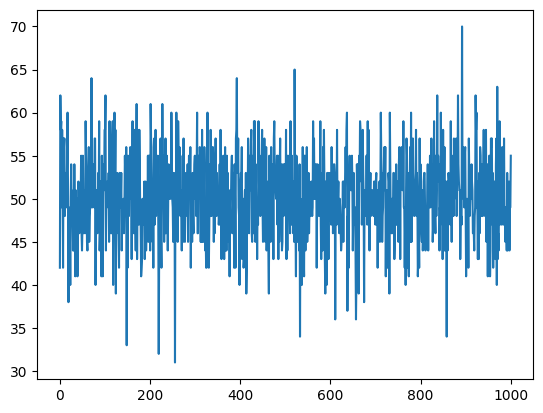

In [78]:
start, end, step = 0, 1000, 1
num = int((end - start) / step)
x = np.linspace(start, end, num=num)
y = np.random.binomial(100, 0.5, num)
print(f'mean: {np.mean(y)}')
print(f'var: {np.var(y)}')
# result of flipping a coin 100 times, tested 1000 times

plt.plot(x, y)
plt.show()

0.2750252974433437


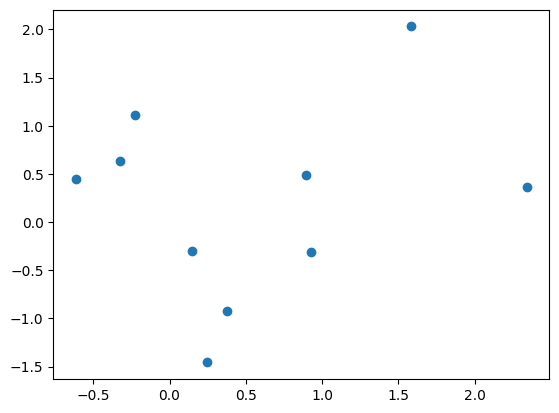

In [112]:
x = np.random.normal(0, 1, size=10)
y = np.random.normal(0, 1, size=10)

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)))

print(cosine_similarity(x, y))

plt.scatter(x, y)
plt.show()

0.8703236191875627


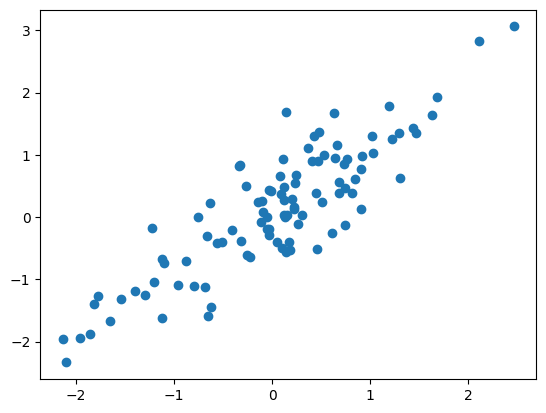

In [117]:
# x and y are highly correlated
x = np.random.normal(0, 1, size=100)
y = x + np.random.normal(0, 0.5, size=100)

print(cosine_similarity(x, y))

plt.scatter(x, y)
plt.show()

用datasets.make_regression()產生資料，並用matplotlib.pyplot.scatter()畫出來。

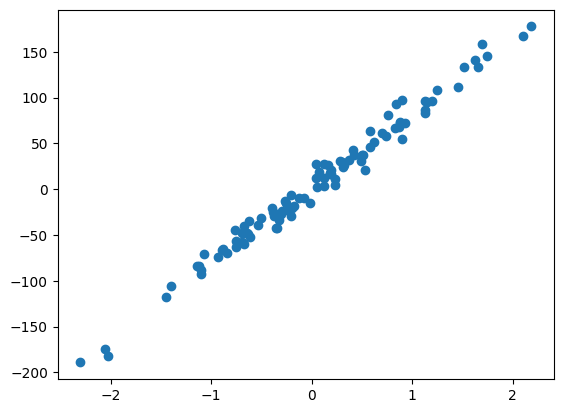

In [50]:
x, y = datasets.make_regression(
    n_samples=100, n_features=1, noise=10, random_state=1)
plt.scatter(x, y)
plt.show()


In [24]:
# get current file path
path = os.getcwd()
movies = pd.read_csv(path + '/data/tmdb_5000_movies.csv')
credits = pd.read_csv(path + '/data/tmdb_5000_credits.csv')

# print(movies.head())
# print(credits.head())

credits.columns = ['id', 'title', 'cast', 'crew']
all_movies = movies.merge(credits, on='id')


In [25]:

df = all_movies[['id', 'original_title', 'genres', 'keywords',
                 'overview', 'original_language', 'cast', 'crew', 'homepage']]  # 只取需要的欄位
features = ['genres', 'keywords', 'cast', 'crew']   # 需要處理的欄位
for feature in features:
    # literal_eval: 將字串轉成python object, provided by ast
    # 例如："[1, 2, 3]" -> [1, 2, 3]
    df.loc[:, feature] = df[feature].apply(literal_eval)


In [26]:

def list_genres(x):
    # extract name of genres from dict type of genres that is processed by literal_eval
    genres = [i['name'] for i in x]
    return genres


def list_keywords(x):
    # extract top 5 keywords
    keywords = [i['name'] for i in x]
    if len(keywords) > 5:
        keywords = keywords[:5]
    return keywords


def list_cast(x):
    cast = [i['name'] for i in x]
    if len(cast) > 3:
        cast = cast[:3]
    return cast


def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


df.loc[:, 'genres'] = df['genres'].apply(list_genres)
df.loc[:, 'keywords'] = df['keywords'].apply(list_keywords)
df.loc[:, 'cast'] = df['cast'].apply(list_cast)
df['director'] = df['crew'].apply(get_director)
df = df.drop('crew', axis=1)

# print(df.head())


C:\Users\abc22\AppData\Local\Temp\ipykernel_12836\2995831844.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'] = df['crew'].apply(get_director)


In [27]:
def clean_feat(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''


features = ['genres', 'keywords', 'cast', 'director']
for feature in features:
    df[feature] = df[feature].apply(clean_feat)


In [28]:
df.head()

,id,original_title,genres,keywords,overview,original_language,cast,homepage,director
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, ...","In the 22nd century, a paraplegic Marine is di...",en,"[samworthington, zoesaldana, sigourneyweaver]",http://www.avatarmovie.com/,jamescameron
1,285,Pirates of the Caribbean: At World's End,"[adventure, fantasy, action]","[ocean, drugabuse, exoticisland, eastindiatrad...","Captain Barbossa, long believed to be dead, ha...",en,"[johnnydepp, orlandobloom, keiraknightley]",http://disney.go.com/disneypictures/pirates/,goreverbinski
2,206647,Spectre,"[action, adventure, crime]","[spy, basedonnovel, secretagent, sequel, mi6]",A cryptic message from Bond’s past sends him o...,en,"[danielcraig, christophwaltz, léaseydoux]",http://www.sonypictures.com/movies/spectre/,sammendes
3,49026,The Dark Knight Rises,"[action, crime, drama, thriller]","[dccomics, crimefighter, terrorist, secretiden...",Following the death of District Attorney Harve...,en,"[christianbale, michaelcaine, garyoldman]",http://www.thedarkknightrises.com/,christophernolan
4,49529,John Carter,"[action, adventure, sciencefiction]","[basedonnovel, mars, medallion, spacetravel, p...","John Carter is a war-weary, former military ca...",en,"[taylorkitsch, lynncollins, samanthamorton]",http://movies.disney.com/john-carter,andrewstanton


In [29]:
df['overview'] = df['overview'].fillna('')


In [30]:
# import nltk

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('wordnet')

df['plotwords'] = ''


def get_keywords(x):
    r = Rake()
    r.extract_keywords_from_text(x)
    return r.get_ranked_phrases()


df['plotwords'] = df['overview'].apply(get_keywords)


In [31]:
def get_keywords(x):
    return (' '.join(x['genres']) + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['plotwords']))


df_key = pd.DataFrame()
df_key['title'] = df['original_title']
df_key['keywords'] = df.apply(get_keywords, axis=1)

df_key.head()


,title,keywords
0,Avatar,action adventure fantasy sciencefiction cultur...
1,Pirates of the Caribbean: At World's End,adventure fantasy action ocean drugabuse exoti...
2,Spectre,action adventure crime spy basedonnovel secret...
3,The Dark Knight Rises,action crime drama thriller dccomics crimefigh...
4,John Carter,action adventure sciencefiction basedonnovel m...


use CountVectorizer to convert keywords to a matrix of token counts, producing the frequency of each word.

In [32]:
count_vector = CountVectorizer()
count_matrix = count_vector.fit_transform(df_key['keywords'])


In [33]:
# create cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim


array([[1.        , 0.10170953, 0.05872202, ..., 0.        , 0.        ,
        0.        ],
       [0.10170953, 1.        , 0.08660254, ..., 0.02318694, 0.        ,
        0.        ],
       [0.05872202, 0.08660254, 1.        , ..., 0.02008048, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02318694, 0.02008048, ..., 1.        , 0.05184758,
        0.03306802],
       [0.        , 0.        , 0.        , ..., 0.05184758, 1.        ,
        0.0531494 ],
       [0.        , 0.        , 0.        , ..., 0.03306802, 0.0531494 ,
        1.        ]])

In [34]:
indices = pd.Series(df_key.index, index=df_key['title'])


In [35]:
def recommend(title, n=10, cosine_sim=cosine_sim):
    movies = []
    homepages = []

    if title not in indices.index:
        print('Movie not in database')
        return movies
    else:
        idx = indices[title]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movie_indices = [i[0] for i in sim_scores]
    movies = df_key['title'].iloc[movie_indices]
    homepages = df['homepage'].iloc[movie_indices]
    return pd.concat([movies, homepages], axis=1)


In [39]:
# 不能保證homepage能用...
print(tabulate(recommend('The Dark Knight Rises', 5), headers=[
      'index', 'title', 'homepage'], tablefmt='rounded_outline'))
print(tabulate(recommend('The Avengers'), headers=[
      'index', 'title', 'homepage'], tablefmt='rounded_outline'))


╭─────────┬─────────────────┬────────────────────────────────────────────────────╮
│   index │ title           │ homepage                                           │
├─────────┼─────────────────┼────────────────────────────────────────────────────┤
│      65 │ The Dark Knight │ http://thedarkknight.warnerbros.com/dvdsite/       │
│     119 │ Batman Begins   │ http://www2.warnerbros.com/batmanbegins/index.html │
│    1359 │ Batman          │ nan                                                │
│     299 │ Batman Forever  │ nan                                                │
│     428 │ Batman Returns  │ nan                                                │
╰─────────┴─────────────────┴────────────────────────────────────────────────────╯
╭─────────┬─────────────────────────────────────┬───────────────────────────────────────────────────────────╮
│   index │ title                               │ homepage                                                  │
├─────────┼──────────────────────